In [1]:
# Import Library
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Cropping2D, Lambda, Conv2D, Activation, Flatten, Dense

print('TensorFlow Version: {}'.format(tf.__version__))
print('Keras Version: {}'.format(keras.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Using TensorFlow backend.


TensorFlow Version: 1.0.0
Keras Version: 2.0.9
No GPU found. Please use a GPU to train your neural network.


In [11]:
# Params
size=(64, 64)
epochs = 10
batch_size = 32

In [3]:
# data prep
list_cars = []
list_notcars = []

images_cars = glob.glob('./data/vehicles/*/*')
images_notcars = glob.glob('./data/non-vehicles/*/*')
for image_file in images_cars:
    list_cars.append(image_file)
for image_file in images_notcars:
    list_notcars.append(image_file)

x = np.hstack((list_cars, list_notcars))
y = np.hstack((np.ones(len(list_cars)), np.zeros(len(list_notcars))))
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

y_train = keras.utils.to_categorical(y_train, 2)
y_valid = keras.utils.to_categorical(y_valid, 2)

In [4]:
def generator(x, y, batch_size=32):
    num_samples = len(x)
    while 1: # Loop forever so the generator never terminates
#         shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_x = x[offset:offset+batch_size]
            batch_y = y[offset:offset+batch_size]

            images = []
            for image_file in batch_x:
                img = plt.imread(image_file)
                images.append(img)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(batch_y)
            
#             X_train = X_train / 255.0 - 0.5
            yield shuffle(X_train, y_train)
    
train_generator = generator(x_train, y_train, batch_size=batch_size)
validation_generator = generator(x_valid, y_valid, batch_size=batch_size)

In [12]:
###############
# Build Model #
###############
model = Sequential()

# # Crop the region not interested, top 50 pixels and bottom 20 pixels
# model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

# Normalize image: x / 255.0 - 0.5
# model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,64,3)))

# Conv1
model.add(Conv2D(24, (5, 5), strides=(2, 2), padding='valid', input_shape=(64,64,3)))
model.add(Activation('relu'))

# Conv2
model.add(Conv2D(36, (5, 5), strides=(2, 2), padding='valid'))
model.add(Activation('relu'))

# Conv3
model.add(Conv2D(48, (5, 5), strides=(2, 2), padding='valid'))
model.add(Activation('relu'))

# Conv4
model.add(Conv2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))

# Conv5
model.add(Conv2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))

# Flatten
model.add(Flatten())

# Fully Connected
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_object = model.fit_generator(generator=train_generator,
                    steps_per_epoch=len(x_train)/batch_size,
                    validation_data=validation_generator,
                    validation_steps=len(x_valid)/batch_size,
                    epochs=epochs)
print('Train Finished.')

Epoch 1/10
444/444 [==============================] - 47s 105ms/step - loss: 0.2940 - acc: 0.8697 - val_loss: 0.1709 - val_acc: 0.9383
Epoch 2/10
444/444 [==============================] - 52s 117ms/step - loss: 0.1068 - acc: 0.9626 - val_loss: 0.0919 - val_acc: 0.9696
Epoch 3/10
444/444 [==============================] - 52s 117ms/step - loss: 0.0667 - acc: 0.9775 - val_loss: 0.0657 - val_acc: 0.9747
Epoch 4/10
444/444 [==============================] - 49s 111ms/step - loss: 0.0522 - acc: 0.9819 - val_loss: 0.0427 - val_acc: 0.9854: 2s - l
Epoch 5/10
444/444 [==============================] - 52s 116ms/step - loss: 0.0373 - acc: 0.9868 - val_loss: 0.0746 - val_acc: 0.9772
Epoch 6/10
444/444 [==============================] - 51s 114ms/step - loss: 0.0292 - acc: 0.9901 - val_loss: 0.0633 - val_acc: 0.9817
Epoch 7/10
444/444 [==============================] - 48s 107ms/step - loss: 0.0284 - acc: 0.9903 - val_loss: 0.0553 - val_acc: 0.9817
Epoch 8/10
444/444 [===========================

In [13]:
model.save('model.h5')
model.save_weights('model_weights.h5')
json_string = model.to_json()  
open('model.json','w').write(json_string)
print('Model Saved.')

Model Saved.


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


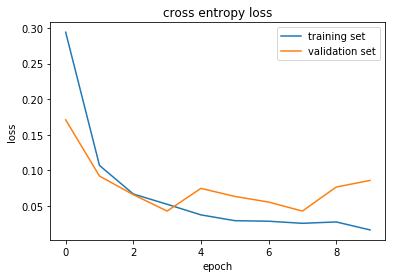

In [14]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('cross entropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

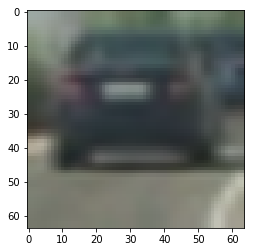

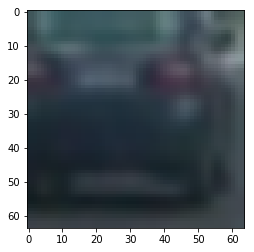

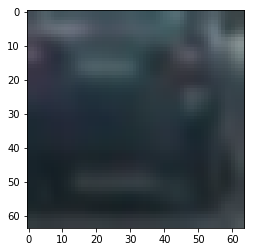

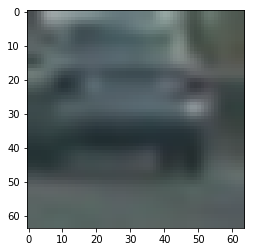

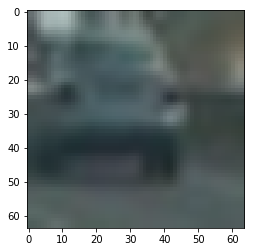

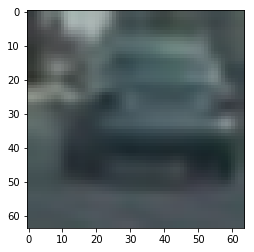

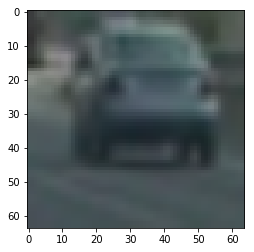

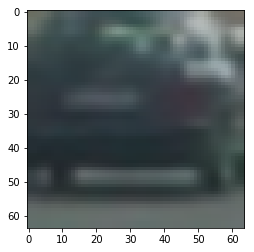

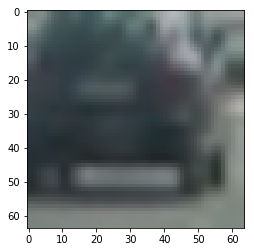

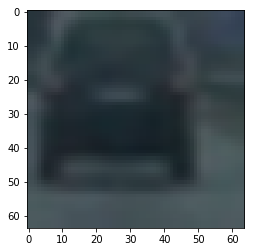

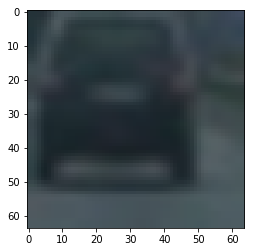

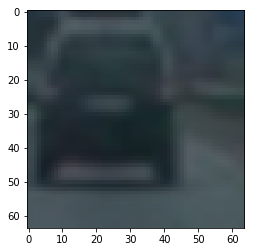

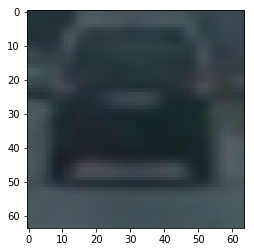

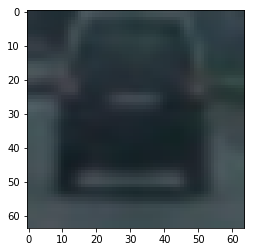

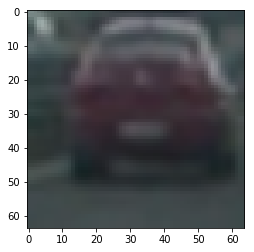

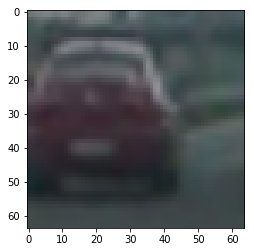

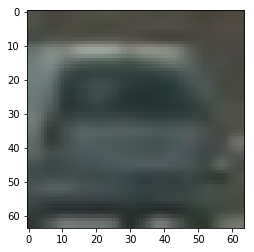

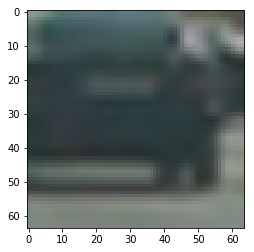

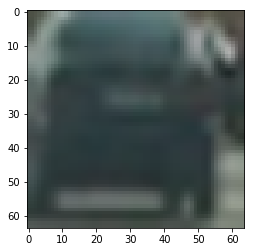

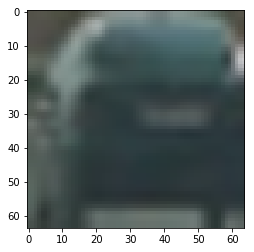

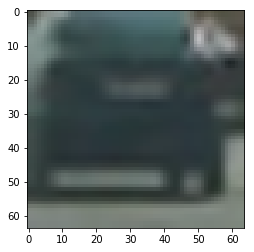

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [15]:
preds = []
for i in range(100):
    img = plt.imread(images_cars[i])
#     img = plt.imread(images_notcars[i])
    x = img.reshape((1,) + img.shape)
#     print(x.shape)
    pred = np.argmax(model.predict(x)[0])
    if(pred == 0):
        plt.figure()
        plt.imshow(img)
        plt.show()
    preds.append(pred)
    
print(preds)
